
# End-to-End Machine Learning using SageMaker

In [ ]:
# first check the python SDK, we will be suing the 1.72 version. if we dont have the same version 
# then insatll the right version

# boto3 :-> to create, access, manage services like EC2 and S3
# execution role that we created in the starting
# sys :-> for system variable and environment
# Ipython :-> command shell

import boto3    
import sagemaker
from sagemaker import get_execution_role
import sys
import IPython

if int(sagemaker.__version__.split('.')[0]) == 2:
    print("Installing previous SageMaker Version and restarting the kernel")
    !{sys.executable} -m pip install sagemaker==1.72.0 # or directly !-m pip insatll will also work
    IPython.Application.instance().kernel.do_shutdown(True)   # restart the kernel

else:
    print("Version is good")


role = get_execution_role()
sess = sagemaker.Session()                    # Manage interactions with the Amazon SageMaker APIs and any other AWS services needed.
region = boto3.session.Session().region_name  # get the region where our notebook will be run
print("Region = {}".format(region))
sm = boto3.Session().client('sagemaker')      # low-level client representing Amazon SageMaker Service

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from time import sleep, gmtime, strftime
import json
import time

In [ ]:
#install sagemaker experiement which keeps tracks of all the experientation we do
# like trying different models, datasets, hyperparameters

# a experient can have multiple trials, each trials can have multiple jobs like preprocessing jobs,
# training jobs etc

!pip install sagemaker-experiments 

from sagemaker.analytics import ExperimentAnalytics
from smexperiments.experiment import Experiment
from smexperiments.trial import Trial 
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker

### Define the Amazon S3 buckets and folders for the project

In [ ]:
rawbucket= sess.default_bucket() # Alternatively you can use our custom bucket here. 

prefix = 'sagemaker-modelmonitor' # use this prefix to store all files pertaining to this workshop.

dataprefix = prefix + '/data'
traindataprefix = prefix + '/train_data'
testdataprefix = prefix + '/test_data'
testdatanolabelprefix = prefix + '/test_data_no_label'
trainheaderprefix = prefix + '/train_headers'

### Download the dataset and import it using the pandas library

In [ ]:
# download the data in the local directory of notebook, here data will not be permananet

! wget https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls
data = pd.read_excel('default of credit card clients.xls', header=1)
data = data.drop(columns = ['ID'])
data.head()

In [ ]:
# move the label column in the second column because XGBoost requires the dataset into this format

data.rename(columns={"default payment next month": "Label"}, inplace=True)
lbl = data.Label
data = pd.concat([lbl, data.drop(columns=['Label'])], axis = 1)
data.head()

### Upload the CSV dataset into an Amazon S3 bucket

In [ ]:

# in the current local directory check if rawdata directory is present or not
# if not present the create a new dir and store the current data to this dir
if not os.path.exists('rawdata/rawdata.csv'):
    !mkdir rawdata
    data.to_csv('rawdata/rawdata.csv', index=None)
else:
    pass
    
# Upload the raw dataset
raw_data_location = sess.upload_data('rawdata', bucket=rawbucket, key_prefix=dataprefix)
print(raw_data_location)

### Process the data using Amazon SageMaker Processing
   * *Here we will preprocess our dataset including scaling the columns  and splitting the dataset into train and test dataset.*
   * *Sagemaker creates a separate compute instance where our preprocessing will be executed.*
   * *sagemaker will create a container which we will have to configure*
   * *this container will fetch the data from S3 and will store the output results back into S3*
   * *Amazon SageMaker provides a managed container for scikit-learn*

In [ ]:
# import the SKLearnProcessor container
from sagemaker.sklearn.processing import SKLearnProcessor

# configure the container
sklearn_processor = SKLearnProcessor(framework_version='0.20.0',    # version of sklearn to use
                                     role=role,                     # our execution role that has IAM
                                     instance_type='ml.c4.xlarge',  # type of instance to have
                                     instance_count=1               # number of instances

# when you've o run the container use sklearn_processor.run(inpout from, outout to)

### create a preprocessing.py file which will be run on preprocessing instance

In [ ]:
# %%writefile preprocessing.py   # %% is magic commands , this will wrte this current cell data into preprocessing.py file

import argparse
import os
import warnings

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.exceptions import DataConversionWarning
from sklearn.compose import make_column_transformer

warnings.filterwarnings(action='ignore', category=DataConversionWarning)

if __name__=='__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--train-test-split-ratio', type=float, default=0.3)
    parser.add_argument('--random-split', type=int, default=0)
    args, _ = parser.parse_known_args()
    
    print('Received arguments {}'.format(args))

    input_data_path = os.path.join('/opt/ml/processing/input', 'rawdata.csv')
    
    print('Reading input data from {}'.format(input_data_path))
    df = pd.read_csv(input_data_path)
    df.sample(frac=1)
    
    COLS = df.columns
    newcolorder = ['PAY_AMT1','BILL_AMT1'] + list(COLS[1:])[:11] + list(COLS[1:])[12:17] + list(COLS[1:])[18:]
    
    split_ratio = args.train_test_split_ratio
    random_state=args.random_split
    
    X_train, X_test, y_train, y_test = train_test_split(df.drop('Label', axis=1), df['Label'], 
                                                        test_size=split_ratio, random_state=random_state)
    
    preprocess = make_column_transformer(
        (['PAY_AMT1'], StandardScaler()),
        (['BILL_AMT1'], MinMaxScaler()),
    remainder='passthrough')
    
    print('Running preprocessing and feature engineering transformations')
    train_features = pd.DataFrame(preprocess.fit_transform(X_train), columns = newcolorder)
    test_features = pd.DataFrame(preprocess.transform(X_test), columns = newcolorder)
    
    # concat to ensure Label column is the first column in dataframe
    train_full = pd.concat([pd.DataFrame(y_train.values, columns=['Label']), train_features], axis=1)
    test_full = pd.concat([pd.DataFrame(y_test.values, columns=['Label']), test_features], axis=1)
    
    print('Train data shape after preprocessing: {}'.format(train_features.shape))
    print('Test data shape after preprocessing: {}'.format(test_features.shape))
    
    train_features_headers_output_path = os.path.join('/opt/ml/processing/train_headers', 'train_data_with_headers.csv')
    
    train_features_output_path = os.path.join('/opt/ml/processing/train', 'train_data.csv')
    
    test_features_output_path = os.path.join('/opt/ml/processing/test', 'test_data.csv')
    
    print('Saving training features to {}'.format(train_features_output_path))
    train_full.to_csv(train_features_output_path, header=False, index=False)
    print("Complete")
    
    print("Save training data with headers to {}".format(train_features_headers_output_path))
    train_full.to_csv(train_features_headers_output_path, index=False)
                 
    print('Saving test features to {}'.format(test_features_output_path))
    test_full.to_csv(test_features_output_path, header=False, index=False)
    print("Complete")

### shift the preprocessing.py file to s3

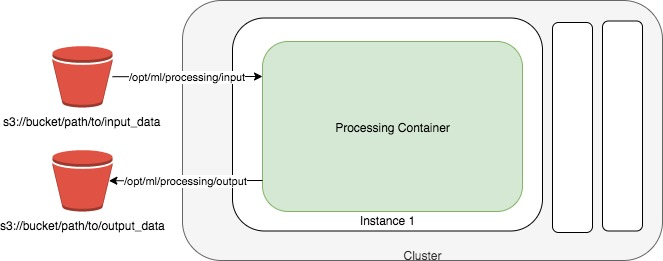

In [ ]:
codeprefix = prefix + '/code'
codeupload = sess.upload_data('preprocessing.py', bucket=rawbucket, key_prefix=codeprefix)
print(codeupload)

# similar to this
# s3://sagemaker-us-east-2-ACCOUNT_NUMBER/sagemaker-modelmonitor/data

### Specify where you want to store your training and test data after the SageMaker Processing job completes. Amazon SageMaker Processing automatically stores the data in the specified location.

In [ ]:
train_data_location = rawbucket + '/' + traindataprefix
test_data_location = rawbucket+'/'+testdataprefix
print("Training data location = {}".format(train_data_location))
print("Test data location = {}".format(test_data_location))

In [ ]:
from sagemaker.processing import ProcessingInput, ProcessingOutput

sklearn_processor.run(code=codeupload,
                      inputs=[ProcessingInput(                                                # from where to read the input s3 bucket local
                                      source=raw_data_location,
                                      destination='/opt/ml/processing/input')],
                      outputs=[ProcessingOutput(output_name='train_data',
                                                source='/opt/ml/processing/train',
                                                destination='s3://' + train_data_location),
                               
                               ProcessingOutput(output_name='test_data',                      # where to store the train data in s3
                                                source='/opt/ml/processing/test',
                                               destination="s3://"+test_data_location),
                               
                               ProcessingOutput(output_name='train_data_headers',
                                                source='/opt/ml/processing/train_headers',    # where to store the test data in S3
                                               destination="s3://" + rawbucket + '/' + prefix + '/train_headers')],
                      arguments=['--train-test-split-ratio', '0.2']
                     )

preprocessing_job_description = sklearn_processor.jobs[-1].describe()

output_config = preprocessing_job_description['ProcessingOutputConfig']
for output in output_config['Outputs']:
    if output['OutputName'] == 'train_data':
        preprocessed_training_data = output['S3Output']['S3Uri']
    if output['OutputName'] == 'test_data':
        preprocessed_test_data = output['S3Output']['S3Uri']


### Create a SageMaker Experiment
  * Now that you have downloaded and staged your dataset in Amazon S3, you can create an Amazon SageMaker Experiment. An experiment is a collection of processing and training jobs related to the same machine learning project. 
  * Amazon SageMaker Experiments automatically manages and tracks your training runs for you.
  * A single experiment can include multiple trials which makes it easy for you to track multiple iterations over time within the Amazon SageMaker Studio Experiments pane.

In [ ]:
# Create a SageMaker Experiment
cc_experiment = Experiment.create(
    experiment_name=f"Build-train-deploy-{int(time.time())}", 
    description="Predict credit card default from payments data", 
    sagemaker_boto_client=sm)
print(cc_experiment)


# Every training job is logged as a trial. Each trial is an iteration of your end-to-end training job. 
# In addition to the training job, it can also track pre-processing and post-processing jobs as well as datasets and other metadata

code to track your pre-processing job under Experiments as well as a step in the training pipeline

In [ ]:
# Start Tracking parameters used in the Pre-processing pipeline.
with Tracker.create(display_name="Preprocessing", sagemaker_boto_client=sm) as tracker:
    tracker.log_parameters({
        "train_test_split_ratio": 0.2,
        "random_state":0
    })
    # we can log the s3 uri to the dataset we just uploaded
    tracker.log_input(name="ccdefault-raw-dataset", media_type="s3/uri", value=raw_data_location)
    tracker.log_input(name="ccdefault-train-dataset", media_type="s3/uri", value=train_data_location)
    tracker.log_input(name="ccdefault-test-dataset", media_type="s3/uri", value=test_data_location)

* *To train an XGBoost classifier, you first **import the XGBoost container maintained by Amazon SageMaker**. Then, you **log the training run under a Trial so SageMaker Experiments can track it under a Trial name**. The **pre-processing job is included under the same trial name** since it is part of the pipeline*
* *Next, **create a SageMaker Estimator object**, which automatically provisions/provides the underlying instance type of your choosing, copies over the training data from the specified output location from the processing job, trains the model, and outputs the model artifacts*

In [ ]:
from sagemaker.amazon.amazon_estimator import get_image_uri

# get the XGbosst base container image
container = get_image_uri(boto3.Session().region_name, 'xgboost', '1.0-1')
s3_input_train = sagemaker.s3_input(s3_data='s3://' + train_data_location, content_type='csv')
preprocessing_trial_component = tracker.trial_component

trial_name = f"cc-default-training-job-{int(time.time())}"
cc_trial = Trial.create(
        trial_name=trial_name, 
            experiment_name=cc_experiment.experiment_name,
        sagemaker_boto_client=sm
    )

cc_trial.add_trial_component(preprocessing_trial_component)
cc_training_job_name = "cc-training-job-{}".format(int(time.time()))

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    train_max_run=86400,
                                    output_path='s3://{}/{}/models'.format(rawbucket, prefix),
                                    sagemaker_session=sess) # set to true for distributed training

xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        verbosity=0,
                        objective='binary:logistic',
                        num_round=100)

xgb.fit(inputs = {'train':s3_input_train},
       job_name=cc_training_job_name,
        experiment_config={
            "TrialName": cc_trial.trial_name, #log training job in Trials for lineage
            "TrialComponentDisplayName": "Training",
        },
        wait=True,
    )
time.sleep(2)

### Deploy the model as EndPoint and establish Data Capture

* Data Capture :--> we capture all the inputs that we recieve

In [ ]:
# sm_client.list_training_jobs 



# will return this

# {
#     'TrainingJobSummaries': [
#         {
#             'TrainingJobName': 'string',
#             'TrainingJobArn': 'string',
#             'CreationTime': datetime(2015, 1, 1),
#             'TrainingEndTime': datetime(2015, 1, 1),
#             'LastModifiedTime': datetime(2015, 1, 1),
#             'TrainingJobStatus': 'InProgress'|'Completed'|'Failed'|'Stopping'|'Stopped'
#         },
#     ],
#     'NextToken': 'string'
# }

In [ ]:
# deploy the model as a RESTful HTTPS endpoint to serve live inferences

from sagemaker.model_monitor import DataCaptureConfig
from sagemaker import RealTimePredictor
from sagemaker.predictor import csv_serializer

# create sagemaker client
sm_client = boto3.client('sagemaker')

# first we list all the training jobs re ran previously, sorting by creation time AND GET ONLY FIRST
latest_training_job = sm_client.list_training_jobs(MaxResults=1,
                                                SortBy='CreationTime',
                                                SortOrder='Descending')

# from the training job that we ran previously, we get the trainingJobName
training_job_name=TrainingJobName=latest_training_job['TrainingJobSummaries'][0]['TrainingJobName']

# contains all the information regarting the training job, like container uri image, model , etc etc
training_job_description = sm_client.describe_training_job(TrainingJobName=training_job_name)



# 1) Provides information about the location that is configured for storing model artifacts.

# 2) Model artifacts are the output that results from training a model, 
#    and typically consist of trained parameters, a model definition that describes how to compute inferences, 
#    and other metadata

model_data = training_job_description['ModelArtifacts']['S3ModelArtifacts']

# The registry path of the Docker image that contains the training algorithm
container_uri = training_job_description['AlgorithmSpecification']['TrainingImage']  

# create a model.
def create_model(role, model_name, container_uri, model_data):
    return sm_client.create_model(
        ModelName=model_name,
        PrimaryContainer={
        'Image': container_uri,
        'ModelDataUrl': model_data,
        },
        ExecutionRoleArn=role)
    

try:
    model = create_model(role, training_job_name, container_uri, model_data)
except Exception as e:
        sm_client.delete_model(ModelName=training_job_name)
        model = create_model(role, training_job_name, container_uri, model_data)
        

print('Model created: '+model['ModelArn'])



# if you run the same cell twice you'll get you are trying to create an model which is already created
# so we delete the model and create again when error pops up
# thata why try: except

* Data Capture
  * *This code tells SageMaker to capture 100% of the inference payloads received by the endpoint, capture both inputs and outputs, and also note the input content type as csv.*
  * *To log the inputs to your endpoint and the inference outputs from SageMaker Real-time endpoints to Amazon S3, you can enable a feature called Data Capture*
  * *Amazon SageMaker Model Monitor automatically parses this captured data and compares metrics from this data with a baseline that you create for the model*
  
  
* *To capture data, you **must deploy a model using SageMaker hosting services**. This requires that you create a SageMaker model, define an endpoint configuration, and create an HTTPS endpoint*

  * *define the **DataCaptureConfig dictionary**, along with required fields, **within the CreateEndpointConfig method to enable data capture.***

  

In [ ]:
# Destination where we will be uploading our captures (lie input and output)
s3_capture_upload_path = 's3://{}/{}/monitoring/datacapture'.format(rawbucket, prefix)


# this config will be used when creating a model encpoint configuration
data_capture_configuration = {
    "EnableCapture": True,        
    "InitialSamplingPercentage": 100,           # capture 100 % of the data
    "DestinationS3Uri": s3_capture_upload_path, # destination of S3
    "CaptureOptions": [                         
        { "CaptureMode": "Output" },            # 
        { "CaptureMode": "Input" }
    ],
    "CaptureContentTypeHeader": {
       "CsvContentTypes": ["text/csv"],
       "JsonContentTypes": ["application/json"]}}

#### Create a EndPoint configuration


In [ ]:
def create_endpoint_config(model_config, data_capture_config): 
    """
    model_config :  'string',
    data_capture_comfig : 'dictionary'
    """
    return sm_client.create_endpoint_config(
                          EndpointConfigName=model_config,
                          ProductionVariants=[
                                  {
                                      'VariantName': 'AllTraffic',       # all the traffic will be directed to this endpoint
                                      'ModelName': model_config,         # model name
                                      'InitialInstanceCount': 1,         # create only 1 instance for inference
                                      'InstanceType': 'ml.m4.xlarge',
                                      'InitialVariantWeight': 1.0,       # Determines initial traffic distribution among all of the models that you specify in the endpoint configuration. 
                                                                          # The traffic to a production variant is determined by the ratio of 
                                                                          # the VariantWeight to the sum of all VariantWeight values across all ProductionVariants. If unspecified, it defaults to 1.0.
                          },
                              
                              ],
                          DataCaptureConfig=data_capture_config            # capture input and output data to endpoint
                          )




try:

    # create a endpoint configuration
    endpoint_config = create_endpoint_config(training_job_name, data_capture_configuration)
except Exception as e:
    sm_client.delete_endpoint_config(EndpointConfigName=endpoint)
    endpoint_config = create_endpoint_config(training_job_name, data_capture_configuration)

print('Endpoint configuration created: '+ endpoint_config['EndpointConfigArn'])

  * To deploy the model, Amazon SageMaker must first copy your model artifacts and inference image onto the instance and set up a HTTPS endpoint to inferface with client applications or RESTful APIs.

### Batch Inferencing

In [ ]:
# copy some rows from test dataset and use it for inferenece on the model endpoint
!head -10 test_data.csv > test_sample.csv

# copies dta to local directory

In [ ]:
# send some inference requests to this endpoint.

from sagemaker import RealTimePredictor
from sagemaker.predictor import csv_serializer

predictor = RealTimePredictor(endpoint=endpoint_name, content_type = 'text/csv')


# open the test_sample and read each row as input or Xq
# we ignore first 2 columns

with open('test_sample.csv', 'r') as f:
    for row in f:
        payload = row.rstrip('\n')
        response = predictor.predict(data=payload[2:])

        # after getting the response, sleep for some time
        sleep(0.5)
print('done!')

In [ ]:
# code to verify that Model Monitor is correctly capturing the incoming data.


# Extract the captured json files.
data_capture_prefix = '{}/monitoring'.format(prefix)

# create a S3 client using boto3 session
sess = boto3.Session()
s3_client = sess.client('s3')

current_endpoint_capture_prefix = '{}/datacapture/{}/AllTraffic'.format(data_capture_prefix, endpoint_name)
print(current_endpoint_capture_prefix)

result = s3_client.list_objects(Bucket=rawbucket, Prefix=current_endpoint_capture_prefix)

capture_files = [capture_file.get("Key") for capture_file in result.get('Contents')]
print("Found Capture Files:")
print("\n ".join(capture_files))


capture_files[0]

In [ ]:
# showing one the outputs from the data captured from the endpoint output

# View contents of the captured file.
def get_obj_body(bucket, obj_key):
    return s3_client.get_object(Bucket=rawbucket, Key=obj_key).get('Body').read().decode("utf-8")

capture_file = get_obj_body(rawbucket, capture_files[0])

# first load the json string fromat dict into python dict format
# then convert back to json fromat string dictionary
print(json.dumps(json.loads(capture_file.split('\n')[5]), indent = 2, sort_keys =True))  




### Monitor the endpoint with SageMaker Model Monitor
  * you enable sagemaker model monitoring for endpoint to monitor data drift
  * Model Monitor provides the following types of monitoring:

      * **[Monitor data quality](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-data-quality.html)** - Monitor drift in data quality.

      * **Monitor model quality** - Monitor drift in model quality metrics, such as accuracy.

      * **Monitor Bias Drift for Models in Production** - Monitor bias in your model's predictions.

      * **Monitor Feature Attribution Drift for Models in Production** - Monitor drift in feature attribution.

In [ ]:
model_prefix = prefix + "/" + endpoint_name     # to store the outputs of the Model Monitor.
baseline_prefix = model_prefix + '/baselining'  # for baseline , data used to training
baseline_data_prefix = baseline_prefix + '/data'  
baseline_results_prefix = baseline_prefix + '/results'

baseline_data_uri = 's3://{}/{}'.format(rawbucket,baseline_data_prefix)
baseline_results_uri = 's3://{}/{}'.format(rawbucket, baseline_results_prefix)
train_data_header_location = "s3://" + rawbucket + '/' + prefix + '/train_headers'

print('Baseline data uri: {}'.format(baseline_data_uri))
print('Baseline results uri: {}'.format(baseline_results_uri))
print(train_data_header_location)

* We will create a baseline job for monitoring which will capture the underlying statistics of the data 

In [ ]:
from sagemaker.model_monitor import DefaultModelMonitor
from sagemaker.model_monitor.dataset_format import DatasetFormat

# configure the baseline processing job instance
my_default_monitor = DefaultModelMonitor(
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    volume_size_in_gb=20,
    max_runtime_in_seconds=3600)

# when we have our datset ready in S3, we ca run the baseline processing job
# which will generate the baseline statistics and baseline constraints for our dataset
# This is an prebuilt container , it'll store the data in output_s3_uri

my_default_monitor.suggest_baseline(
    baseline_dataset=os.path.join(train_data_header_location, 'train_data_with_headers.csv'),
    dataset_format=DatasetFormat.csv(header=True),
    output_s3_uri=baseline_results_uri,
    wait=True
)

# this will generate a lot spark jobs, so just ignore them

In [ ]:
# lets look at the output of the baseline jobs

sess = boto3.Session()
s3_client = sess.client('s3')


result = s3_client.list_objects(Bucket=rawbucket, Prefix=baseline_results_prefix)
report_files = [report_file.get("Key") for report_file in result.get('Contents')]
print("Found Files:")
print("\n ".join(report_files))

# we can see two files constraints.json and statistics.json. 
# get the latest baseline job 
baseline_job = my_default_monitor.latest_baselining_job

# converts the statsics.json data into pandas dataframe
schema_df = pd.io.json.json_normalize(baseline_job.baseline_statistics().body_dict["features"])
schema_df

constraints_df = pd.io.json.json_normalize(baseline_job.suggested_constraints().body_dict["features"])
constraints_df

### We want to frequently check for data drift, so lets setup how frequently we want to perform monitoring

In [ ]:

# Model Monitor will produce a report consisting of all the violations it finds, they'll be stored here
reports_prefix = '{}/reports'.format(prefix)   
s3_report_path = 's3://{}/{}'.format(rawbucket, reports_prefix)
print(s3_report_path)

from sagemaker.model_monitor import CronExpressionGenerator
from time import gmtime, strftime

mon_schedule_name = 'Built-train-deploy-model-monitor-schedule-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

my_default_monitor.create_monitoring_schedule(
    monitor_schedule_name=mon_schedule_name,
    endpoint_input=predictor.endpoint,
    output_s3_uri=s3_report_path,
    statistics=my_default_monitor.baseline_statistics(),
    constraints=my_default_monitor.suggested_constraints(),
    schedule_cron_expression=CronExpressionGenerator.hourly(),
    enable_cloudwatch_metrics=True,

)

# Note that this code enables Amazon CloudWatch Metrics, which instructs Model Monitor to send outputs to CloudWatch
# You can use this approach to trigger alarms using CloudWatch Alarms to let engineers or admins know when data drift has been detected

### Test SageMaker Model Monitor performance
  * We will evaluate the performance of model monitor. we will feed a sample of data which will be different form original data. We modify the distribution of certain features and in the test dataset to check if data monitor detects some change

In [ ]:
# here is a sampel of data we will be using

COLS = data.columns
test_full = pd.read_csv('test_data.csv', names = ['Label'] + ['PAY_AMT1','BILL_AMT1'] + list(COLS[1:])[:11] + list(COLS[1:])[12:17] + list(COLS[1:])[18:]
)
test_full.head()

In [ ]:
faketestdata = test_full
# changing some columns types, values and basic distribution

faketestdata['EDUCATION'] = -faketestdata['EDUCATION'].astype(float)
faketestdata['BILL_AMT2']= (faketestdata['BILL_AMT2']//10).astype(float)
faketestdata['AGE']= (faketestdata['AGE']-10).astype(float)

faketestdata.head()
faketestdata.drop(columns=['Label']).to_csv('test-data-input-cols.csv', index = None, header=None)

* why use runtime.sagemaker ? 
  * when we have to invoke the endpoint we use sagemaker runtime which is created using boto3.Client() creating a low level client representing Sagemaker runtime

In [ ]:
from threading import Thread

runtime_client = boto3.client('runtime.sagemaker')

# (just repeating code from above for convenience/ able to run this section independently)
def invoke_endpoint(ep_name, file_name, runtime_client):
    with open(file_name, 'r') as f:
        for row in f:
            payload = row.rstrip('\n')
            response = runtime_client.invoke_endpoint(EndpointName=ep_name,
                                          ContentType='text/csv', 
                                          Body=payload)
            time.sleep(1)
            
def invoke_endpoint_forever():
    while True:
        invoke_endpoint(endpoint, 'test-data-input-cols.csv', runtime_client)
        
thread = Thread(target = invoke_endpoint_forever)
thread.start()
# Note that you need to stop the kernel to stop the invocations

In [ ]:
desc_schedule_result = my_default_monitor.describe_schedule()
print('Schedule status: {}'.format(desc_schedule_result['MonitoringScheduleStatus']))